In [1]:
import torch 
import matplotlib.pyplot as plt  
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import random 
%matplotlib inline   
import torch.nn as nn
%matplotlib inline  
chars = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z', 'a1', 'b1', 'c1', 'd1',
    'e1', 'f1', 'g1', 'h1', 'i1', 'j1', 'k1', 'l1', 'm1',
    'n1', 'o1', 'p1', 'q1', 'r1', 's1', 't1', 'u1', 'v1', 'w1'
]  
stoi = {s:i+1 for i,s in enumerate(chars)}   
stoi["."] = 0     
itos = {i:s for s,i in stoi.items()}   
file_path = 'mapped_words.txt'    
unknown_index = stoi.get('Unknown', 0)  
tokensize = 8
packets = open(file_path, 'r').read().splitlines()    
def build_dataset(packets) : 
    xs , ys = [] , []  
    for packet in packets :   
        context = [0]*tokensize 
        temppacket = packet.split(' ')  
        for ch in temppacket : 
            ix1 = stoi.get(ch, unknown_index)
            xs.append(context) 
            ys.append(ix1) 
            context = context[1:]  + [ix1] 
    return torch.tensor(xs) ,  torch.tensor(ys)   
random.shuffle(packets)   
n1 = int(0.8*len(packets))
n2 = int(0.9*len(packets))
Xtr, Ytr = build_dataset(packets[:n1])
Xdev, Ydev = build_dataset(packets[n1:n2])
Xte, Yte = build_dataset(packets[n2:])    



In [2]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [3]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP   
vocab_size = 50 
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

80098


In [4]:
max_steps = 1000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/   1000: 3.8985
      1/   1000: 3.6421
      2/   1000: 3.4237
      3/   1000: 2.8590
      4/   1000: 2.8661
      5/   1000: 2.7214
      6/   1000: 2.6694
      7/   1000: 2.1364
      8/   1000: 2.6908
      9/   1000: 2.5986
     10/   1000: 2.3914
     11/   1000: 2.3011
     12/   1000: 2.7790
     13/   1000: 2.2395
     14/   1000: 2.8624
     15/   1000: 1.9706
     16/   1000: 2.2073
     17/   1000: 2.6985
     18/   1000: 2.4434
     19/   1000: 2.5906
     20/   1000: 1.7322
     21/   1000: 1.9671
     22/   1000: 1.6578
     23/   1000: 2.1373
     24/   1000: 2.2568
     25/   1000: 2.2118
     26/   1000: 2.0109
     27/   1000: 2.3754
     28/   1000: 2.4324
     29/   1000: 2.5505
     30/   1000: 2.3145
     31/   1000: 1.6545
     32/   1000: 1.7876
     33/   1000: 1.8954
     34/   1000: 1.9348
     35/   1000: 1.8813
     36/   1000: 1.5797
     37/   1000: 1.9797
     38/   1000: 2.2889


/home/mohammad/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     39/   1000: 1.5430
     40/   1000: 1.4398
     41/   1000: 1.8503
     42/   1000: 1.8146
     43/   1000: 1.6904
     44/   1000: 1.9147
     45/   1000: 1.4964
     46/   1000: 1.0623
     47/   1000: 1.6866
     48/   1000: 1.0649
     49/   1000: 1.7603
     50/   1000: 1.7698
     51/   1000: 1.2737
     52/   1000: 1.2133
     53/   1000: 1.6688
     54/   1000: 1.3973
     55/   1000: 2.0622
     56/   1000: 1.6047
     57/   1000: 1.2031
     58/   1000: 1.4499
     59/   1000: 1.5309
     60/   1000: 1.9048
     61/   1000: 1.4272
     62/   1000: 1.7611
     63/   1000: 0.8632
     64/   1000: 1.6225
     65/   1000: 1.2744
     66/   1000: 1.2676
     67/   1000: 1.2864
     68/   1000: 1.6322
     69/   1000: 1.8011
     70/   1000: 1.4291
     71/   1000: 1.5844
     72/   1000: 0.8605
     73/   1000: 0.8377
     74/   1000: 0.9605
     75/   1000: 0.9777
     76/   1000: 0.9266
     77/   1000: 1.6621
     78/   1000: 1.7382
     79/   1000: 1.0660
     80/   1000:

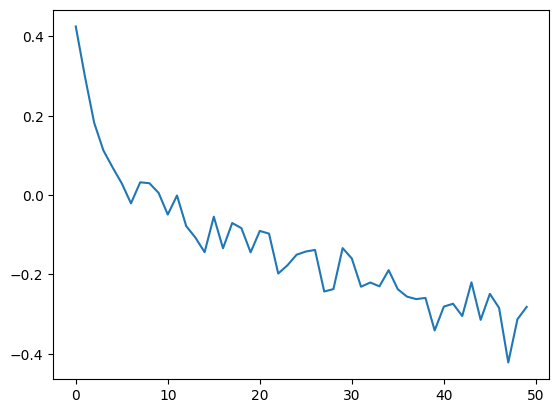

In [5]:
plt.plot(torch.tensor(lossi).view(-1,20).mean(1))


In [6]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [7]:
model 

In [8]:
out_put = []

for _ in range(1000): 
        out = []  
        context = [0] * 8
        j = 0     
        while len(out)<79 :    
                    logits = model(torch.tensor([context]))  
                    probs = F.softmax(logits, dim=1) 
                    ix = torch.multinomial(probs, num_samples=1).item() 
                    context = context[1:] + [ix]  
                    out.append(ix) 
                    

              
        out_put.append(str(''.join(itos[i] for i in out)))

In [12]:
out_put[:10]

['c1ohqp1b1za1p1w1h1w1r1aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaomaddomoooammmaomnimmmlan1cpaaaaa',
 'oohqmi1vkdp1v1q1n1aaaaaaaaaaaaaaaaaaaaomkijttuaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'e1ohpp1a1wxddomoooammmaomaw1n1klaaaaaabng1aaaaaaaaaaaaaaaaaaaaaaaomaddomoooammmaomnip',
 'sokjks1aagataylaaaaaaaaaaaaaomaddomoooammmaomniplllaaaaaaaaaaaaaaaaaadng1aaaaaaaa',
 'd1ohv1o1a1xytdaaaaaaataalng1aaaaaaaaaaaaaomaff1j1ppaaaaaaaaaf1p1hi1h1otaaaaaaaaaung1aaaaaaa',
 'e1ohknaaaaaaataajh1ij1j1j1v1v1v1t1r1u1k1i1r1n1q1i1n1b1aaaaaaaaaaaadng1aaaaaaaaaadng1aaaaaaaaaaaaaaaa',
 'e1okpr1fkt1hazp1pwmj1q1aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaadng1aaaaaaaaaaaaaaaaaaaa',
 '.f1d1hiv1yu1w1aw1st1po1avaaaaaaaaaaaaaaaaaaaaaaaaaaaabng1aaaaaaaaaaaaaaaaaaaaaaaaaaomadd',
 'f1oc1rkn1wwk1aaaaaaaaaaaaaak1ng1aaaaaaaaaaaaaaaomaddompooammmaomniplllaaaaaaaaaaaaaaa',
 'g1ohro1yzvddomoooammmaomniplllaaaaaaaaaaaaaaaaaaaaaaaaaanpog1i1m1k1q1vyq1aaaaaaaaaaaaaa']

In [14]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

: 